# Reinforcement Learning "Hello World"

## Copyright

*Copyright Geoscience DS&ML Special Interest Group, 2022.*
*License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)*
*Author(s): [Altay Sansal](https://github.com/tasansal)*

## Prerequisites

NOTE: This notebook requires wildcatter installed with the `hello_world` extra. To do this install wildcatter via:
```shell
pip install wildcatter[hello_world]
```

This notebook assumes familiarity with Reinforcement Learning concepts (agents, spaces, actions, ...) and knowledge of [OpenAI's Gym](https://www.gymlibrary.ml/) APIs and environments. If you are not familiar with RL or Gym at all, we refer the reader to the following resources:
1. [OpenAI Gym Introduction](https://www.gymlibrary.ml/content/api/)
2. [OpenAI Gym Introduction](https://www.gymlibrary.ml/content/api/)
3. [OpenAI Spinning Up in Deep RL](https://spinningup.openai.com/en/latest/)
    * [Part 1: Key Concepts in RL](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html)
    * [Part 2: Kinds of RL Algorithms](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html)
    * [Part 3: Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html)
    * [Key Papers](https://spinningup.openai.com/en/latest/spinningup/keypapers.html)
    * [RL Algorithms](https://spinningup.openai.com/en/latest/user/algorithms.html)
4. [David Silver's RL Course](https://www.davidsilver.uk/teaching/)
5. [Berkeley's Deep RL Bootcamp](https://sites.google.com/view/deep-rl-bootcamp/lectures)
6. [PyTorch DQN from Scratch](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
7. [OpenAI Gym Tutorials](https://www.gymlibrary.ml/content/tutorials/)
8. [More Resources](https://github.com/dennybritz/reinforcement-learning#resources)
9. [If you like MATLAB...](https://www.mathworks.com/products/reinforcement-learning.html)

First two resources are bare-minimum, but for the curious minded, we included more detailed resources!

## Introduction

Here we will be using an environment from `Gym`. The environment we choose is the `CartPole-v1`, which is a part of the classic control system environments.

The problem we are trying to solve is trying to keep a pole upright, which is attached to a frictionless cart with an un-actuated joint. The goal is to balance the pole by moving the cart to the left or to the right.

Untrained environment looks like this:
<img src="https://www.gymlibrary.ml/_images/cart_pole.gif" width="350"/>

More information about the environment can be found [here](https://www.gymlibrary.ml/environments/classic_control/cart_pole/) and the source code for the environment can be found [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).

The environment has the following action and observation spaces:

| Property          | Details             |
|-------------------|---------------------|
| Action Space      | `Discrete(2)`       |
| Observation Space | `Box(4, 'float32')` |

Action Space:

| Num | Action                 |
|:---:|------------------------|
|  0  | Push cart to the left  |
|  1  | Push cart to the right |

Observation Space:

| Num | Action                |     Min      |     Max     |
|:---:|-----------------------|:------------:|:-----------:|
|  0  | Cart Position         |    `-4.8`    |    `4.8`    |
|  1  | Cart Velocity         |    `-inf`    |    `inf`    |
|  2  | Pole Angle            | `-0.418 rad` | `0.418 rad` |
|  3  | Pole Angular Velocity |    `-inf`    |    `inf`    |

The environment will terminate automatically (send a `done` signal) if the pole's angle is more than 12 degrees (0.20944 rad) or if the position of the cart is +/- 2.4, meaning cart reaches the end of the display.

Let's take a more detailed look!

We first import `gym` and make the environment. Then we will look at its pre-configured action space and observation space using built in attributes.

In [1]:
import gym

env_id = "CartPole-v1"
env = gym.make(env_id)

In [2]:
env.action_space

Discrete(2)

In [3]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

Here let's see what the observation state looks like if we reset the environment five times.

In [4]:
for idx in range(5):
    print(f"reset {idx + 1}", env.reset())

reset 1 [0.01656609 0.02576861 0.0039965  0.01861649]
reset 2 [-0.03452398 -0.04903302 -0.0241876   0.03794585]
reset 3 [-0.02339839  0.01897064  0.00293178 -0.03030473]
reset 4 [ 0.0366796  -0.00294616  0.00407595 -0.00959057]
reset 5 [-0.00534603  0.04765269 -0.00063244  0.04559017]


As expected, we can see the cart and pole parameters are all different once we reset the environment.

Reminder: Values are `[cart_position, cart_velocity, pole_angle(rad), pole_angular_velocity]`.

Now let's reset the environment and take up to 100 steps. Since there is no trained model, the actions we sample are going to be randomly selected from the action space. The expectation here is to fail after ~20 time steps.

The boilerplate code is to visualize in Jupyter Notebook. Normally this would pop up a window using Pyglet and will visualize the current state of the system when the `.render()` method is called.

Here, the returned variables are **observation** which is the current state, the **reward** is the current reward for the action we have taken (not cumulative), **done** states if the environment finished, or failed etc., and finally **info** is a diagnostic variable (if we included things in the `step` implementation). In the cartpole environment, the info is empty.

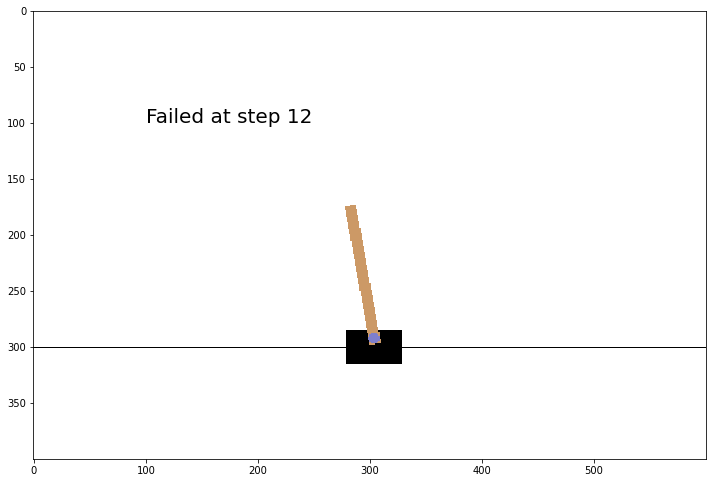

In [5]:
from IPython import display
import matplotlib.pyplot as plt

%matplotlib inline

obs = env.reset()

fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(env.render(mode="rgb_array"), interpolation="none")
fig.tight_layout()

done = False
for idx in range(100):
    img.set_data(env.render(mode="rgb_array"))
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    if done:
        plt.text(100, 100, f"Failed at step {idx}", fontsize=20)
        break

if not done:
    plt.text(100, 100, f"Stable until step {idx + 1}", fontsize=20)

env.close()

# Training An Agent

We chose to use the Proximal Policy Optimization (PPO) algorithm with a Multi-Layer Perceptron (MLP, also known as Feedforward Fully-Connected Neural Network) policy to make our agent learn how to balance a stick! Some other popular algorithms are Deep Q-Network (DQN), Advantage Actor Critic (A2C), and more. A very extensive list of RL algorithms can be found [here](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html).

However, keep in mind, this is a very simple RL problem. Typically, RL algorithms require a lot of hyperparameter tuning.

In this example, due to its simplicity, we are using the [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/) library. This does allow many configuration options. However, for production scale RL and high performance training, the industry standard is [Ray](https://docs.ray.io/en/latest/index.html)'s [RLlib](https://docs.ray.io/en/latest/rllib/index.html).

For tunable parameters of PPO, we recommend checking out the Stable Baselines3 documentation (below). The PPO explained article is also helpful in understanding the parameters and their meanings.

More information about PPO:
* [PPO Paper](https://arxiv.org/abs/1707.06347)
* [Understanding PPO Plots](https://medium.com/aureliantactics/understanding-ppo-plots-in-tensorboard-cbc3199b9ba2)
* [OpenAI Spinning Up PPO](https://spinningup.openai.com/en/latest/algorithms/ppo.html)
* [PPO Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)
* [PPO Explained - Article](https://jonathan-hui.medium.com/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12)
* [PPO Keras from Scratch](https://keras.io/examples/rl/ppo_cartpole/)

We will first let it train for 10,000 time-steps. We will also evaluate it on 10 episodes to and get its average score.

In [6]:
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10_000, log_interval=5)

mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"10 evaluation runs mean reward = {mean_reward}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 63.2         |
|    ep_rew_mean          | 63.2         |
| time/                   |              |
|    fps                  | 1657         |
|    iterations           | 5            |
|    time_elapsed         | 6            |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0070142997 |
|    clip_fraction        | 0.0708       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.601       |
|    explained_variance   | 0.254        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.6         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0167      |
|    value_loss           | 70.3         |
------------------------------------------
10 

Now let's visualize the trained agent.

Note that now the action is being predicted by the model, instead of sampling randomly from the action space.

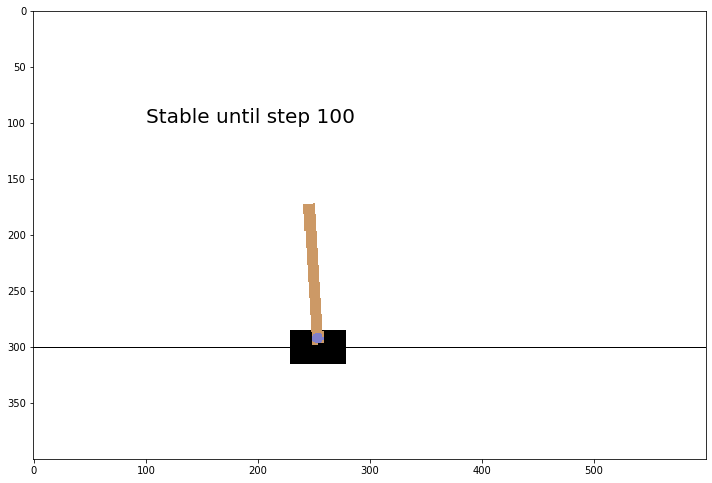

In [7]:
from IPython import display
import matplotlib.pyplot as plt

%matplotlib inline

obs = env.reset()

fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(env.render(mode="rgb_array"), interpolation="none")
fig.tight_layout()

done = False
for idx in range(100):
    img.set_data(env.render(mode="rgb_array"))
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)

    if done:
        plt.text(100, 100, f"Failed at step {idx}", fontsize=20)
        break

if not done:
    plt.text(100, 100, f"Stable until step {idx + 1}", fontsize=20)

env.close()

Let's train for more time.

In [8]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=60_000, log_interval=15)

mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"10 evaluation runs mean reward = {mean_reward}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 236          |
|    ep_rew_mean          | 236          |
| time/                   |              |
|    fps                  | 1526         |
|    iterations           | 15           |
|    time_elapsed         | 20           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0048547667 |
|    clip_fraction        | 0.0299       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.523       |
|    explained_variance   | 0.052        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0786       |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.000506    |
|    value_loss           | 1.98         |
------------------------------------------
---

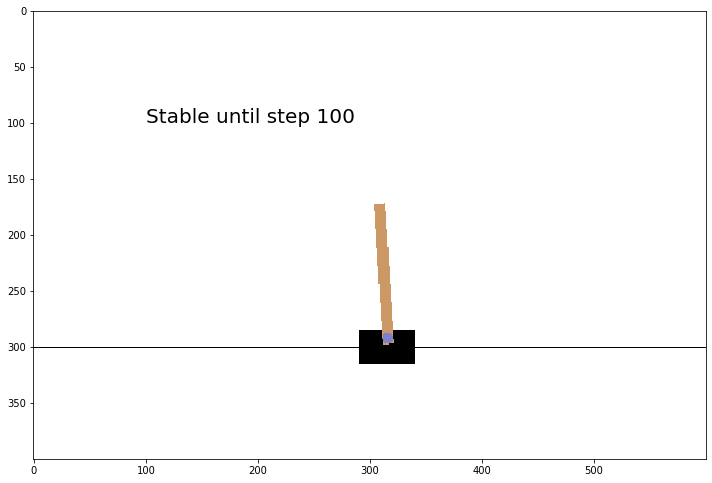

In [9]:
from IPython import display
import matplotlib.pyplot as plt

%matplotlib inline

obs = env.reset()

fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(env.render(mode="rgb_array"), interpolation="none")
fig.tight_layout()

done = False
for idx in range(100):
    img.set_data(env.render(mode="rgb_array"))
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)

    if done:
        plt.text(100, 100, f"Failed at step {idx}", fontsize=20)
        break

if not done:
    plt.text(100, 100, f"Stable until step {idx + 1}", fontsize=20)

env.close()

The new agent is much better at balancing the pole. If we increased the training steps to above 100,000 it is hard to see that the pole is even moving!

# Conclusions
* We learned about the CartPole environment.
* We trained a simple RL environment using PPO algorithm.

# Next Steps
If you want to improve your RL skills from here, we recommend:
1. Use different OpenAI Gym environments to practice.
2. Try different RL algorithms (links above).
3. Try hyperparameter tuning with Ray RLlib (links above).
4. Implement your own environment for wildcatter!
5. Check out Stable Baselines3 or RLlib TensorBoard integration [here](https://stable-baselines3.readthedocs.io/en/master/guide/tensorboard.html) and [here](https://docs.ray.io/en/latest/rllib/rllib-training.html).